<a href="https://colab.research.google.com/github/Pbrillan/CEIA/blob/main/NLP/Pbrillan_2b_bot_dnn_spacy_esp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot basado en reglas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [1]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

In [2]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [3]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

2022-03-28 20:56:12 INFO: Downloading default packages for language: es (Spanish)...
2022-03-28 20:56:15 INFO: File exists: /root/stanza_resources/es/default.zip.
2022-03-28 20:56:24 INFO: Finished downloading models and saved to /root/stanza_resources.
2022-03-28 20:56:24 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2022-03-28 20:56:24 INFO: Use device: cpu
2022-03-28 20:56:24 INFO: Loading: tokenize
2022-03-28 20:56:25 INFO: Loading: mwt
2022-03-28 20:56:25 INFO: Loading: pos
2022-03-28 20:56:25 INFO: Loading: lemma
2022-03-28 20:56:25 INFO: Loading: depparse
2022-03-28 20:56:25 INFO: Loading: ner
2022-03-28 20:56:27 INFO: Done loading processors!


In [4]:
# Stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

nltk_stop_words = set(stopwords.words("spanish"))
#filtered_sentence = [w for w in nltk_punctuation if w not in nltk_stop_words]
#print("Stop words filter:", filtered_sentence)
print(nltk_stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'vuestras', 'soy', 'tendría', 'tenéis', 'estarían', 'yo', 'estar', 'estuviésemos', 'porque', 'estados', 'fueseis', 'todo', 'estaban', 'tuve', 'tenga', 'hayamos', 'te', 'seáis', 'seréis', 'fui', 'estuvieras', 'sea', 'tuviéramos', 'habíais', 'tendremos', 'también', 'había', 'entre', 'estad', 'fueses', 'has', 'era', 'serías', 'estuvieron', 'sentidas', 'suyas', 'teníamos', 'mías', 'habidos', 'estaré', 'estaba', 'mí', 'estarán', 'habida', 'tuvieses', 'sentido', 'tenemos', 'estuvimos', 'hubiésemos', 'estabas', 'sería', 'habías', 'ante', 'hube', 'muy', 'tuvieron', 'fuimos', 'le', 'tuvieran', 'estaríais', 'o', 'hubiéramos', 'habré', 'se', 'serán', 'estaría', 'habríamos', 'del', 'por', 'él', 'estado', 'es', 'otro', 'me', 'tú', 'tuyos', 'habréis', 'habían', 'sin', 'estuviste', 'seríais', 'hubiste', 'tuvieseis', 'que', 'fuisteis', 'esté', 'tendré', 'como', 'míos', 'seríamos', 't

### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [5]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    #text = ''.join([w for w in text if w not in nltk_stop_words])
    # sacar tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntiación
    text = ''.join([c for c in text if c not in string.punctuation])
    text = text.split(" ")
    text = ' '.join([c for c in text if c not in nltk_stop_words])
    #text2 =""
    #print(text)
    #for w in text: 
    #  if w not in nltk_stop_words:
    #    print(w)
    #    text2 += " " + w
    #print(text)
    #print(text2)
    return text

In [6]:
text = "personas Ideas! estás cosas y los peces y los muercielagos"

    
# Antes de preprocesar los datos se pasa a mínusculas todo el texto
preprocess_clean_text(text.lower())


'personas ideas cosas peces muercielagos'

In [7]:
# Ejemplo de como fuciona
text = "hola personas Ideas! estás cosas y los peces y los muercielagos"

# Antes de preprocesar los datos se pasa a mínusculas todo el texto
tokes = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokes)
print("Lematización de cada token:")
for token in tokes:
    print([token, token.lemma_])

tokens: hola personas ideas cosas peces muercielagos
Lematización de cada token:
[hola, 'holar']
[personas, 'persona']
[ideas, 'idea']
[cosas, 'cosa']
[peces, 'pez']
[muercielagos, 'muercielago']


### 3 - Diccionario de entrada

In [8]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?", "¿Hay alguien ahí?", "Buenos días", "Buenas tardes", "Buenas noches", "Buenas"],
              "responses": ["Hola!", "Hola, ¿Cómo estás?"],
             },
             {"tag": "nombre",
              "patterns": ["¿Cúal es tu nombre?", "¿Quién sos?"],
              "responses": ["Mi nombre es TiendaPro", "Yo soy TiendaPro"]
             },
            {"tag": "contacto",
              "patterns": ["contacto", "número de contacto", "número de teléfono", "número de whatsapp", "whatsapp"],
              "responses": ["Podes contactarnos al siguiente <numero>", "Contactos al whatsapp <numero>"]
             },
            {"tag": "envios",
              "patterns": ["¿Realizan envios?", "¿Cómo me llega el paquete?"],
              "responses": ["Tenemos diferentes formas de envios según la zona, te recomiendo entrar a este <link>"]
             },
            {"tag": "precios",
              "patterns": ["precio", "Me podrás pasar los precios", "¿Cuánto vale?", "¿Cuánto sale?"],
              "responses": ["En el siguiente link podrás encontrar los precios de todos nuestros productos en stock"]
             },
            {"tag": "pagos",
              "patterns": ["medios de pago", "tarjeta de crédito", "tarjetas", "cuotas"],
              "responses": ["En el siguiente link podrás encontrar los beneficios y formas de pago vigentes"]
             },
            {"tag": "stock",
              "patterns": ["Esto está disponible", "¿Tenes stock?", "¿Hay stock hoy?"],
              "responses": ["Los productos publicados están en stock"]
             },
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias"],
              "responses": ["Por nada!, cualquier otra consulta podes escribirme"]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!", "Nos vemos", "saludos!"],
              "responses": ["Hasta luego!", "Hablamos luego!"]
             }
]}

### 4 - Preprocesamiento y armado del dataset

In [9]:
# Datos que necesitaremos, las palabras o vocabilario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para lamacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [10]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['ahi', 'alguien', 'buen', 'chau', 'contacto', 'credito', 'cuanto', 'cuota', 'dia', 'disponible', 'envio', 'gracias', 'holar', 'hoy', 'llegar', 'luego', 'medio', 'mucho', 'noche', 'nombre', 'numerar', 'numero', 'pago', 'paquete', 'pasar', 'poder', 'precio', 'realizar', 'salir', 'saludo', 'ser', 'stock', 'tal', 'tarde', 'tarjeta', 'telefono', 'tener', 'valer', 'ver', 'whatsapp']
classes: ['agradecimientos', 'bienvenida', 'contacto', 'despedida', 'envios', 'nombre', 'pagos', 'precios', 'stock']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', '¿Hay alguien ahí?', 'Buenos días', 'Buenas tardes', 'Buenas noches', 'Buenas', '¿Cúal es tu nombre?', '¿Quién sos?', 'contacto', 'número de contacto', 'número de teléfono', 'número de whatsapp', 'whatsapp', '¿Realizan envios?', '¿Cómo me llega el paquete?', 'precio', 'Me podrás pasar los precios', '¿Cuánto vale?', '¿Cuánto sale?', 'medios de pago', 'tarjeta de crédito', 'tarjetas', 'cuotas', 'Esto está disponible', '¿Tenes stock?', '¿Hay stock h

In [11]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 40


In [12]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 9


In [13]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    freq = []
    print(text)
    for word in words:
      
      bow.append(1) if word in text else bow.append(0)
      

    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

['holar']
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
[]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
['tal']
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
['alguien', 'ahi']
X: [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
['buen', 'dia']
X: [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
['buen', 'tarde']
X: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0,

### 5 - Entrenamiento del modelo

In [14]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (40,) output: 9


In [15]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               5248      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 9)                 585       
                                                                 
Total params: 14,089
Trainable params: 14,089
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
2/2 [==============================] - 1s 7ms/step - loss: 2.2722 - accuracy: 0.0000e+00
Epoch 2/200
2/2 [==============================] - 0s 8ms/step - loss: 2.2427 - accuracy: 0.1176
Epoch 3/200
2/2 [==============================] - 0s 5ms/step - loss: 2.1862 - accuracy: 0.1176
Epoch 4/200
2/2 [==============================] - 0s 8ms/step - loss: 2.2391 - accuracy: 0.0882
Epoch 5/200
2/2 [==============================] - 0s 6ms/step - loss: 2.2524 - accuracy: 0.1176
Epoch 6/200
2/2 [==============================] - 0s 7ms/step - loss: 2.1880 - accuracy: 0.0882
Epoch 7/200
2/2 [==============================] - 0s 6ms/step - loss: 2.2307 - accuracy: 0.0588
Epoch 8/200
2/2 [==============================] - 0s 6ms/step - loss: 2.2098 - accuracy: 0.1176
Epoch 9/200
2/2 [==============================] - 0s 6ms/step - loss: 2.2082 - accuracy: 0.1471
Epoch 10/200
2/2 [==============================] - 0s 6ms/step - loss: 2.1255 - accuracy: 0.2059
Epoch 11/200
2/2 [=======

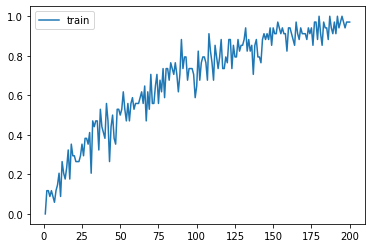

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [18]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [19]:
def text_to_tokens(text): 
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0:
        result = model.predict(np.array([bow]))[0]
        thresh = 0.2
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]
    list_of_intents = intents_json["intents"]
    for i in list_of_intents: 
        if i["tag"] == tag:
            result = "BOT: " + random.choice(i["responses"])
            break
    return result

In [21]:
while True:
    message = input("")
    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print(result)
    else:
        print("Perdón, no comprendo la pregunta.")
    

hola
BOT: Hola!
buen
BOT: Hola!
como va
Perdón, no comprendo la pregunta.
como estas
Perdón, no comprendo la pregunta.
cuanto
BOT: En el siguiente link podrás encontrar los precios de todos nuestros productos en stock
cual
Perdón, no comprendo la pregunta.
 cuales
Perdón, no comprendo la pregunta.
cuen
Perdón, no comprendo la pregunta.
cuanto
BOT: En el siguiente link podrás encontrar los precios de todos nuestros productos en stock
cual
Perdón, no comprendo la pregunta.
envío
Perdón, no comprendo la pregunta.
envios
BOT: Tenemos diferentes formas de envios según la zona, te recomiendo entrar a este <link>
chau
BOT: Hasta luego!
nos vemos
BOT: Hasta luego!
bye
Perdón, no comprendo la pregunta.


KeyboardInterrupt: ignored

### 7 - Conclusiones
El bot tal cual está definido es capaz de responder a bastantes tipos de preguntas con gran precisión. Algunas técnicas que podrían ensayarse para evaluar como impactan en el sistema son:
- Filtrar los stop words
- Utilizar TF-IDF en vez de bag of words